In [1]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from configuration import *
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from qm import SimulationConfig, LoopbackInterface
import Labber


from qm.octave import *
from qm.qua import *
import os
import time
from qualang_tools.units import unit
from set_octave import get_L0_and_IF


from qualang_tools.loops import from_array,get_equivalent_log_array
from qualang_tools.plot import interrupt_on_close
from qualang_tools.results import progress_counter, fetching_tool
from resonator_tools import circuit 

import sys
#Path for HQCPC7 
sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Analysis_Function\NonLinearRes')
sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Drivers\Drivers') #path for the analysis function
sys.path.append(r"\C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\QM_NonLinRes\Calibration_Script")

# #Path for HQC PC15 
# sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Analysis_Function\NonLinearRes')
# sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Drivers')
import AnFunc as an # analysis function
import imageio
from Signal_hound_driver import Signalhound 
from lmfit.models import LinearModel

from qualang_tools.units import unit
u = unit()

import Calibration_function as calib

In [2]:
def update_offset(offset_1, offset_2,config,qmm):
    """ Update the input offsets of the qm in the configuration file """
    
    config['controllers']["con1"]["analog_inputs"][1]['offset']=offset_1
    config['controllers']["con1"]["analog_inputs"][2]['offset']=offset_2
    
    
    qm=qmm.open_qm(config)
    
    return config, qm

def update_readout_lenght(Readout_Len,config,qmm):
    """ Macro to update the readout length in the configuration file"""
    
    config["pulses"]["zero_pulse"]["length"]=Readout_Len
    config["integration_weights"]["cosine_weights"]["cosine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["cosine_weights"]["sine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["sine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["sine"][0]=(-1.0, Readout_Len)


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm


def update_pulse_amplitude(pulse_amp,config,qmm):
    config["waveforms"]["twoPhoton_wf"]['sample']=pulse_amp
    
    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm

def update_two_photon_lenght(twoPhoton_len,config,qmm):
    """ Update the length of the fluxline pulse in the configuration file"""
    config["pulses"]["twoPhoton"]["length"]=twoPhoton_len


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm

def update_resonator_pulse_length(resonator_len,config,qmm):
        
    config["pulses"]["const"]["length"]=resonator_len #Length of the pumping pulse=twoPhoton_len


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm


def Resonator_Power_Monitoring(sgh,amplitude_array, n_points):
    
    Spec_amp=np.zeros(len(amplitude_array))
    pulse_time=2_000_000_000//4
    
    amplitude_array=amplitude_array.tolist()
    
    #defines the program 
    with program() as calib_amp:

        a=declare(fixed)

        with for_each_(a,amplitude_array):

            play("cw"*amp(a), "resonator",duration=pulse_time) #Plays the pump pulse on the flux line 
            pause() # pause to collect the data from the trigger 


    job = qm.execute( calib_amp)  # Execute QUA program  


    for j in range(len(amplitude_array)):
        while not job.is_paused():
            time.sleep(0.001)


        print(j)
        #time.sleep()
        sgh.IQ(n_points)
        time.sleep(0.5)


        b=sgh.iqArr[0:].reshape(int(len(sgh.iqArr[0:])/2),2)
        Spec_amp[j]=np.mean(np.sqrt(b[:,0]**2+b[:,1]**2))*1000

        job.resume()  # Resume to the program
        
   

    return Spec_amp


def Pump_Power_Monitoring(sgh,amplitude_array, n_points):
    
    Spec_amp=np.zeros(len(amplitude_array))
    pulse_time=2_000_000_000//4
    
    #defines the program 
    with program() as calib_amp:

        a=declare(fixed)

        with for_(*from_array(a,amplitude_array)):

            play("pumping"*amp(a), "fluxline",duration=pulse_time) #Plays the pump pulse on the flux line 
            pause() # pause to collect the data from the trigger 


    job = qm.execute(calib_amp)  # Execute QUA program  


    for j in range(len(amplitude_array)):
        while not job.is_paused():
            time.sleep(0.001)


        print(j)
        #time.sleep()
        sgh.IQ(n_points)
        time.sleep(0.5)


        b=sgh.iqArr[0:].reshape(int(len(sgh.iqArr[0:])/2),2)
        Spec_amp[j]=np.mean(np.sqrt(b[:,0]**2+b[:,1]**2))*1000

        job.resume()  # Resume to the program
        
   

    return Spec_amp



def SingleResonatorSpec(n_avg, cooldown_time, f_min, f_max, df, amp_factor,plot=True): 
    
    freqs = np.arange(f_min, f_max + 0.1, df)
    
    with program() as resonator_spec:

        n = declare(int)
        f = declare(int)
        I = declare(fixed)
        Q = declare(fixed)
        I_st = declare_stream()
        Q_st = declare_stream()
        n_st= declare_stream()

        with for_(n, 0, n < n_avg, n + 1):

            with for_(f, f_min, f <= f_max, f + df):  # Notice it's <= to include f_max (This is only for integers!)

                update_frequency("resonator", f)

                measure(
                    "cw"*amp(amp_factor),
                    "resonator",
                    None,
                    dual_demod.full("cos", "out1", "sin", "out2", I),
                    dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
                )

                wait(cooldown_time, "resonator") #Waiting time between sucessive measure 

                save(I, I_st)
                save(Q, Q_st)

            save(n, n_st)

        with stream_processing():

            I_st.buffer(len(freqs)).average().save("I") #Fills all the buffer frequency and then average the sucessive 
            Q_st.buffer(len(freqs)).average().save("Q")
            n_st.save("iteration")

    simulate = False

    if simulate:

        simulation_config = SimulationConfig(duration=10000)
        job = qmm.simulate(config, resonator_spec, simulation_config)
        job.get_simulated_samples().con1.plot(analog_ports={'1','2'},digital_ports={'1'})

    else:

        qm = qmm.open_qm(config)
        job = qm.execute(resonator_spec)

        # Get results from QUA program
        results = fetching_tool(job, data_list=["I", "Q", "iteration"], mode="live")

        # Live plotting
        fig = plt.figure()
    

        while results.is_processing():
            # Fetch results
            I, Q, iteration = results.fetch_all()
            
                # Convert I & Q to Volts
            I = u.demod2volts(I, pulse_len)
            Q = u.demod2volts(Q, pulse_len)
            
            progress_counter(iteration, n_avg, start_time=results.get_start_time())

            # Plot results
            plt.subplot(211)
            plt.cla()
            plt.title("resonator spectroscopy amplitude")
            plt.plot(freqs / u.MHz, 20*np.log10(np.sqrt(I**2 + Q**2)/(amp_factor)), ".")
            plt.xlabel("frequency [MHz]")
            plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [a.u.]")
            plt.subplot(212)
            plt.cla()
            # detrend removes the linear increase of phase
            phase = signal.detrend(np.unwrap(np.angle(I + 1j * Q)))
            plt.title("resonator spectroscopy phase")
            plt.plot(freqs / u.MHz, phase, ".")
            plt.xlabel("frequency [MHz]")
            plt.ylabel("Phase [rad]")
            plt.pause(0.1)
            plt.tight_layout()
            
            
    
    f=freqs+LO_readout 
    
    port=circuit.notch_port()
    port.add_data(f,I+ 1j*Q)
    port.autofit()
    
    if plot==True : 

        fig, axs = plt.subplots( nrows=1, ncols=3, figsize=(26/2.54, 6/2.54),dpi=200)
        figsize=(8/2.54, 6/2.54)
        dpi=300
        fontsize=5

        #fig.suptitle("Output VNA power "+str(y_0[idx]) +" dB", fontsize=8)



        ax=axs[0]
        ax.plot(port.z_data_raw.real, port.z_data_raw.imag,"o", ms=0.5)
        ax.plot(port.z_data_sim.real, port.z_data_sim.imag,"-")
        ax.set_title("S21",fontsize=fontsize)
        ax.set_xlabel("Real value [S21]",fontsize=fontsize)
        ax.set_ylabel("Imag value [S21]",fontsize=fontsize)
        ax.tick_params(axis='x', labelsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)


        ax=axs[1]
        ax.plot(f/1e9, np.abs(port.z_data_raw),"o", ms=0.5)
        ax.plot(f/1e9, np.abs(port.z_data_sim),"-")
        ax.set_title("Amplitude",fontsize=fontsize)
        ax.set_xlabel("Frequency [GHz]",fontsize=fontsize)
        ax.set_ylabel("Amplitude ",fontsize=fontsize)
        ax.tick_params(axis='x', labelsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)



        ax=axs[2]
        ax.plot(f/1e9, np.angle(port.z_data_raw),"o", ms=0.5)
        ax.plot(f/1e9, np.angle(port.z_data_sim),"-")
        ax.set_title("Phase",fontsize=fontsize)
        ax.set_xlabel("Frequency [GHz]",fontsize=fontsize)
        ax.set_ylabel("Phase [rad]",fontsize=fontsize)
        ax.tick_params(axis='x', labelsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)
    resonance_frequency=port.fitresults["fr"]
    error_frequency=port.fitresults['fr_err']


    print("The measured resonance frequency is {} GHz with an error of {} GHz".format(port.fitresults["fr"]/1e9,port.fitresults['fr_err']/1e9))

 
    return freqs,I,Q,resonance_frequency, error_frequency


def full_power_calibration(sgh,amplitude_array_res, amplitude_array_pump, IF_readout, LO_readout, IF_fluxline, LO_fluxline): 


    center_freq=LO_readout+IF_readout
    span=5e3 #does not change anything 
    ref_level=-30

    decimation=1
    bandwidth=250e3

    sgh.setSweepParameters(center_freq,span)
    sgh.setRefLevel(ref_level)
    sgh.setGainAtten()
    sgh.setIQ(decimation,bandwidth)
    sgh.setProcUnit("mV")
    sgh.setSweepMode("IQ")


    #amplitude factor 
    n_points=4000

    amp_calib_res=Resonator_Power_Monitoring(qm,sgh,amplitude_array_res, n_points)


    model=LinearModel()
    params=model.make_params(slope=1, intercept=0)
    result=model.fit(amp_calib_res,params, x=amplitude_array_res)

    plt.plot(amplitude_array_res,amp_calib_res,".")
    plt.xlabel("Amp factor")
    plt.ylabel("Signal hound")
    plt.plot(amplitude_array_res, result.best_fit)

    slope_res=result.params["slope"].value
    intercept_res=result.params["intercept"].value

    #Initial values 
    init_value=np.array([0.67150983, 3.35454778, 6.70839427])
    init_slope=6.7076
    init_intercept=0.0007366


    print("Variation relative to the first calibration {}".format(amp_calib_res/init_value))
    print("Slope relative to the first intercept {}".format(slope_res/init_slope))
    print("Intercept relative to the first intercept {}".format(intercept_res/init_intercept))



    center_freq=LO_fluxline+IF_fluxline
    span=5e3 #does not change anything 
    ref_level=-30

    decimation=1
    bandwidth=250e3

    sgh.setSweepParameters(center_freq,span)
    sgh.setRefLevel(ref_level)
    sgh.setGainAtten()
    sgh.setIQ(decimation,bandwidth)
    sgh.setProcUnit("mV")
    sgh.setSweepMode("IQ")


    n_points=4000

    amp_calib_pump=Pump_Power_Monitoring(qm,sgh,amplitude_array_pump, n_points)


    model=LinearModel()
    params=model.make_params(slope=1, intercept=0)
    result=model.fit(amp_calib_pump,params, x=amplitude_array_pump)

    plt.plot(amplitude_array_pump,amp_calib_pump,".")
    plt.xlabel("Amp factor")
    plt.ylabel("Signal hound")
    plt.plot(amplitude_array_pump, result.best_fit)

    slope_pump=result.params["slope"].value
    intercept_pump=result.params["intercept"].value

    #Initial values 
    init_value=np.array([ 8.51846766,  9.51669272, 10.51835343, 11.51051931, 12.51635142])
    init_slope=9.989594109112204
    init_intercept=0.02700


    print("Variation relative to the first calibration {}".format(amp_calib_pump/init_value))
    print("Slope relative to the first intercept {}".format(slope_pump/init_slope))
    print("Intercept relative to the first intercept {}".format(intercept_pump/init_intercept))
    
    return amp_calib_pump, amp_calib_res

In [3]:
#Octave & OPX configuration 
Saving_Path=r"\\sb1files\HQC\Users\beaulieu\Data\Run01\131\\"
Cooldown_Date="2023_07_08"

calibration_path='C:\\Users\\HQClabo\\Documents\\Code\\QuantumMachine\\Guillaume\\NonLinearRes_calib_30_03_2023\\QM_NonLinRes\\Calibration_Script'

opx_ip = '128.178.175.167'
opx_port = 81
octave_ip = '128.178.175.167'
octave_port = 53

octave_config = QmOctaveConfig()
octave_config.set_calibration_db(calibration_path) #Path to the calibration database 

octave_config.add_device_info('octave1', octave_ip, octave_port) #Add a device refered to as octave 1
octave_config.set_opx_octave_mapping([('con1', 'octave1')])  # set default mapping between analog outputs of OPX and the octave

qmm = QuantumMachinesManager(host=opx_ip, port=opx_port, octave=octave_config)
qm = qmm.open_qm(config)

octave_output_gain=-10

#Mixers for the fluxline 
qmm.octave_manager.set_clock("octave1", ClockType.External, ClockFrequency.MHZ_10) # External clock on the octave 

qm.octave.set_lo_source("fluxline", OctaveLOSource.Internal) # Use internal LO for the fluxline 
qm.octave.set_lo_frequency("fluxline", LO_fluxline)  # Set the frequency of the LO 
qm.octave.set_rf_output_gain("fluxline", octave_output_gain)  # can set gain from -10dB to 20dB
qm.octave.set_rf_output_mode("fluxline", RFOutputMode.on)  # The LO output is always on (could change to a trigger)  #RFOutputMode.trig_normal

#Mixers for the resonator 
qm.octave.set_qua_element_octave_rf_in_port("resonator", "octave1", 1) #input port 1 is set for the resonator 
qm.octave.set_downconversion("resonator", lo_source=RFInputLOSource.Internal)  # The LO for the demodulation is the interal LO  

qm.octave.set_lo_source("resonator", OctaveLOSource.Internal) # Use internal LO for the fluxline 
qm.octave.set_lo_frequency("resonator", LO_readout)  # Set the frequency of the LO 
qm.octave.set_rf_output_gain("resonator", octave_output_gain)  # can set gain from -10dB to 20dB
qm.octave.set_rf_output_mode("resonator",RFOutputMode.trig_normal)  # The LO output is always on (could change to a trigger)RFOutputMode.trig_normal


2023-07-17 10:37:29,595 - qm - INFO - Performing health check
2023-07-17 10:37:29,610 - qm - WARNING -   HC Warning: Potential hardware issue with QSync in controller con1, multiple controllers sync cannot be guaranteed, please inform QM
2023-07-17 10:37:29,610 - qm - INFO - Health check passed


# Calibration at the octave 

In [7]:
#Calibration of resonator frequency and pump at the octave 
qm.octave.calibrate_element("fluxline", [get_L0_and_IF(config, "fluxline")])  
qm = qmm.open_qm(config)

qm.octave.calibrate_element("resonator", [get_L0_and_IF(config, "resonator")])  
qm = qmm.open_qm(config)

2023-07-11 10:30:19,947 - qm - INFO - Flags: 
2023-07-11 10:30:19,948 - qm - INFO - Compiling program
2023-07-11 10:30:22,265 - qm - INFO - Sending pre-compiled program to QOP
2023-07-11 10:30:26,018 - qm - INFO - Flags: 
2023-07-11 10:30:26,018 - qm - INFO - Compiling program
2023-07-11 10:30:28,361 - qm - INFO - Sending pre-compiled program to QOP


# ADC & time of flight calibration

This allows checking that the ADC is not saturated to set a proper gain, correct for DC offsets and define the time of flight.
For this, we send a Twophoton pulse and look at the the raw adc 



In [6]:
#Sets the pulse length and the pulse amplitude at the resonator 
Readout_Len=100_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

twoPhoton_len=100_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)


amp_factor=1.05 #Amplitude factor of the pump 

n_avg = 1000  # Number of averaging loops

IF_pump=99471960 # if to be at twice the resoance frequency 
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout

Readout_Delay=10_000//4 # Delay before the first readout in ns (convert from clockcycle)
points_delay=16//4

offset_1=0.01783981341796875
offset_2=0.01553899095214844
config,qm=update_offset(offset_1, offset_2,config,qmm)

In [7]:
%matplotlib qt

with program() as raw_trace_prog:
    
    n = declare(int)
    adc_st = declare_stream(adc_trace=True)
    i = declare(int)
    
    update_frequency("resonator",IF_resonator) 
    update_frequency("fluxline",IF_pump)

    
    wait(Readout_Delay,"resonator")
    
    

    with for_(i, 0, i < np.round((n_avg*(Readout_Len+300+points_delay*4)+Readout_Delay*4)/twoPhoton_len)+1, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle 
        play("pumping" * amp(amp_factor), 'fluxline')  # Play the pulse on the fluxline
        
    with for_(n, 0, n < n_avg, n + 1):
        
        #play("pumping"*amp(amp_factor), 'fluxline')
        #Delay time before the first readout 
        measure("fake_readout", "resonator", adc_st)
        
        wait(points_delay,"resonator")

    with stream_processing():
        
        # Will save average:
        adc_st.input1().average().save("adc1")
        adc_st.input2().average().save("adc2")
        
        # Will save only last run:
        adc_st.input1().save("adc1_single_run")
        adc_st.input2().save("adc2_single_run")

        
simulation = False
if simulation:
    
    simulation_config = SimulationConfig(
        duration=80000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    job = qmm.simulate(config, raw_trace_prog, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})
    
    
    
else: 
    #Execute the program     
    qm = qmm.open_qm(config)
    job = qm.execute(raw_trace_prog)

    results = fetching_tool(job, data_list=["adc1", "adc2", "adc1_single_run","adc2_single_run"], mode="wait_for_all")

    adc1, adc2, adc1_single_run, adc2_single_run = results.fetch_all()

    adc1 = u.raw2volts(adc1)
    adc2 = u.raw2volts(adc2)
    adc1_single_run = u.raw2volts(adc1_single_run)
    adc2_single_run = u.raw2volts(adc2_single_run)

    #Plotting 
    plt.figure()
    plt.subplot(121)
    plt.title("Single run")
    plt.plot(adc1_single_run, label="Input 1")
    plt.plot(adc2_single_run, label="Input 2")
    plt.xlabel("Time [ns]")
    plt.ylabel("Signal amplitude [V]")
    plt.legend()

    plt.subplot(122)
    plt.title("Averaged run")
    plt.plot(adc1, label="Input 1")
    plt.plot(adc2, label="Input 2")
    plt.xlabel("Time [ns]")
    plt.legend()
    plt.tight_layout()

    print("The mean offset of port 1 is: {}".format(np.mean(adc1)))
    print("The mean offset of port 2 is: {}".format(np.mean(adc2)))

2023-07-09 15:29:57,904 - qm - INFO - Flags: 
2023-07-09 15:29:57,905 - qm - INFO - Sending program to QOP
2023-07-09 15:29:57,986 - qm - INFO - Executing program
The mean offset of port 1 is: -1.45000634765625e-05
The mean offset of port 2 is: 8.85349072265625e-05


# Resonator Measurement 

In [6]:
%matplotlib qt

#Sets the pulse length and the pulse amplitude at the resonator 
pulse_len=50_000
config,qm=update_readout_lenght(pulse_len,config,qmm)

#number of average 
n_avg = 1000

#Waiting time before succesive readout 
cooldown_time = 50_000 // 4

#If frequency sweep of the resonator 

f_min =149.75e6-0.25e6
f_max =149.75e6+0.25e6
df = 0.0025e6   #0.001e6 #0.001e6


amp_factor=0.01 #amplitude factor 

In [8]:
freqs,I,Q,resonance_frequency, error_frequency=SingleResonatorSpec(n_avg, cooldown_time, f_min, f_max, df, amp_factor,plot=True)

2023-07-14 17:21:13,361 - qm - INFO - Flags: 
2023-07-14 17:21:13,362 - qm - INFO - Sending program to QOP
2023-07-14 17:21:14,365 - qm - INFO - Executing program
Progress: [##################################################] 100.0% (n=1000/1000) --> elapsed time: 20.04s
Progress: [##################################################] 100.0% (n=1000/1000) --> elapsed time: 20.22s
The measured resonance frequency is 4.349750433807814 GHz with an error of 7.387646629299804e-07 GHz


# Calibration test pump

In [6]:
dll_path=r"C:\\Program Files\\Signal Hound\\Spike\\sa_api.dll"
sgh=Signalhound()
#open the device
sgh.performOpen(dll_path)

Unable to open device SignalHound


In [119]:
center_freq=LO_fluxline
span=500e6
ref_level=-20
rbw=100e3
vbw=rbw

sgh.setSweepParameters(center_freq,span)
sgh.setRefLevel(ref_level)
sgh.setGainAtten()
sgh.setSweepCoupling(rbw,vbw)
sgh.setProcUnit("dbm")
sgh.setSweepMode("sweeping")

In [120]:
amp_factor=1.05


with program() as hello_octave:
    with infinite_loop_():
        play("pumping"*amp(amp_factor), "fluxline")
        
job = qm.execute(hello_octave)



_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = ""
	debug_error_string = "{"created":"@1688908482.127000000","description":"Error received from peer ipv4:128.178.175.167:81","file":"src/core/lib/surface/call.cc","file_line":967,"grpc_message":"","grpc_status":2}"
>

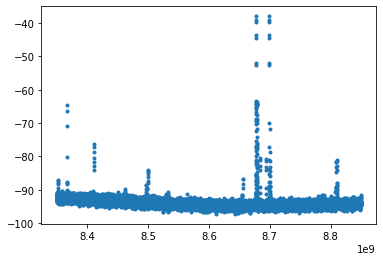

In [89]:
sgh.SingleSweep()
plt.plot(sgh.freq, sgh.trace,".")

In [121]:
job.halt()

True

In [6]:
sgh.performClose()

# Calibration test resonator

In [76]:
amp_factor=1


with program() as hello_octave:
    with infinite_loop_():
        play("cw"*amp(amp_factor), "resonator")
        
job = qm.execute(hello_octave)



2023-07-09 13:41:40,237 - qm - INFO - Flags: 
2023-07-09 13:41:40,238 - qm - INFO - Sending program to QOP
2023-07-09 13:41:40,473 - qm - INFO - Executing program


In [77]:
job.halt()

True

# Resonator power monitoring

In [4]:
dll_path=r"C:\\Program Files\\Signal Hound\\Spike\\sa_api.dll"
sgh=Signalhound()
#open the device
sgh.performOpen(dll_path)


center_freq=LO_readout+IF_readout
span=5e3 #does not change anything 
ref_level=-30

decimation=1
bandwidth=250e3

sgh.setSweepParameters(center_freq,span)
sgh.setRefLevel(ref_level)
sgh.setGainAtten()
sgh.setIQ(decimation,bandwidth)
sgh.setProcUnit("mV")
sgh.setSweepMode("IQ")

2023-07-17 10:37:44,069 - qm - INFO - Flags: 
2023-07-17 10:37:44,069 - qm - INFO - Sending program to QOP
2023-07-17 10:37:44,101 - qm - INFO - Executing program
0
1
2
Variation relative to the first calibration [0.99066229 0.99048056 0.99017886]
Slope relative to the first intercept 0.990122474938347
Intercept relative to the first intercept 1.9056831495157571


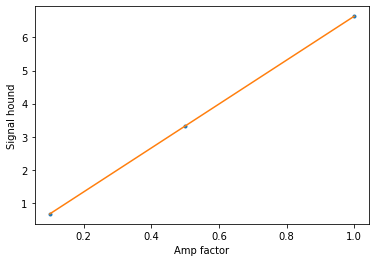

In [5]:
#amplitude factor 
amplitude_array=np.array([0.1, 0.5,1])
n_points=4000

amp_calib=Resonator_Power_Monitoring(sgh,amplitude_array, n_points)


model=LinearModel()
params=model.make_params(slope=1, intercept=0)
result=model.fit(amp_calib,params, x=amplitude_array)

plt.plot(amplitude_array,amp_calib,".")
plt.xlabel("Amp factor")
plt.ylabel("Signal hound")
plt.plot(amplitude_array, result.best_fit)

slope=result.params["slope"].value
intercept=result.params["intercept"].value

#Initial values 
init_value=np.array([0.67150983, 3.35454778, 6.70839427])
init_slope=6.7076
init_intercept=0.0007366


print("Variation relative to the first calibration {}".format(amp_calib/init_value))
print("Slope relative to the first intercept {}".format(slope/init_slope))
print("Intercept relative to the first intercept {}".format(intercept/init_intercept))

In [7]:
amp_calib

array([0.66523947, 3.32261436, 6.64251018])

In [8]:
sgh.performClose()

# Pump power monitoring



In [9]:
dll_path=r"C:\\Program Files\\Signal Hound\\Spike\\sa_api.dll"
sgh=Signalhound()
#open the device
sgh.performOpen(dll_path)


center_freq=LO_fluxline+IF_fluxline
span=5e3 #does not change anything 
ref_level=-30

decimation=1
bandwidth=250e3

sgh.setSweepParameters(center_freq,span)
sgh.setRefLevel(ref_level)
sgh.setGainAtten()
sgh.setIQ(decimation,bandwidth)
sgh.setProcUnit("mV")
sgh.setSweepMode("IQ")

2023-07-17 10:38:25,679 - qm - INFO - Flags: 
2023-07-17 10:38:25,680 - qm - INFO - Sending program to QOP
2023-07-17 10:38:25,706 - qm - INFO - Executing program
0
1
2
3
4
Variation relative to the first calibration [1.00898457 1.00841008 1.00894108 1.00786473 1.00853272]
Slope relative to the first intercept 0.9780504733802015
Intercept relative to the first intercept 1.5199098334086154


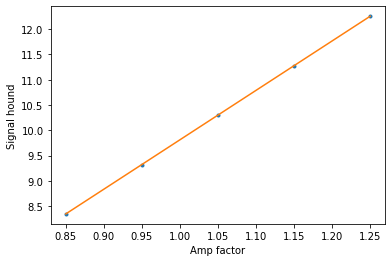

In [10]:
#amplitude factor 
amplitude_array=np.array([0.85,0.95,1.05,1.15,1.25])
n_points=4000

amp_calib=Pump_Power_Monitoring(sgh,amplitude_array, n_points)


model=LinearModel()
params=model.make_params(slope=1, intercept=0)
result=model.fit(amp_calib,params, x=amplitude_array)

plt.plot(amplitude_array,amp_calib,".")
plt.xlabel("Amp factor")
plt.ylabel("Signal hound")
plt.plot(amplitude_array, result.best_fit)

slope=result.params["slope"].value
intercept=result.params["intercept"].value

#Initial values 
init_value=np.array([ 8.27149488,  9.24304314, 10.21174528, 11.18881255, 12.14929204])
init_slope=9.989594109112204
init_intercept=0.02700


print("Variation relative to the first calibration {}".format(amp_calib/init_value))
print("Slope relative to the first intercept {}".format(slope/init_slope))
print("Intercept relative to the first intercept {}".format(intercept/init_intercept))

In [11]:
amp_calib

array([ 8.3458107 ,  9.32077784, 10.30304935, 11.2768095 , 12.25295849])

In [12]:
sgh.performClose()

# Full power monitoring 

In [6]:
dll_path=r"C:\\Program Files\\Signal Hound\\Spike\\sa_api.dll"
sgh=Signalhound()
#open the device
sgh.performOpen(dll_path)


In [9]:
sgh.performClose()

During saCloseDevice, the error -3 was raised


2023-07-09 20:39:15,720 - qm - INFO - Flags: 
2023-07-09 20:39:15,720 - qm - INFO - Sending program to QOP
2023-07-09 20:39:16,046 - qm - INFO - Executing program
0
1
2
Variation relative to the first calibration [1.00079478 1.00134984 1.00048285]
Slope relative to the first intercept 1.0004216656191547
Intercept relative to the first intercept 2.7456880361417
2023-07-09 20:39:23,848 - qm - INFO - Flags: 
2023-07-09 20:39:23,848 - qm - INFO - Sending program to QOP
2023-07-09 20:39:23,921 - qm - INFO - Executing program
0
1
2
3
4
Variation relative to the first calibration [0.99620276 0.99686861 0.99723313 0.99687515 0.99645072]
Slope relative to the first intercept 0.9969645482855936
Intercept relative to the first intercept 0.9079118495977743


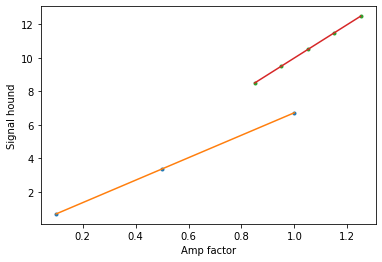

In [12]:

amplitude_array_res=np.array([0.1, 0.5,1])
amplitude_array_pump=np.array([0.85,0.95,1.05,1.15,1.25])

amp_calib_pump, amp_calib_res=full_power_calibration(sgh,amplitude_array_res, amplitude_array_pump, IF_readout, LO_readout, IF_fluxline, LO_fluxline)

2023-07-09 20:55:32,830 - qm - INFO - Flags: 
2023-07-09 20:55:32,831 - qm - INFO - Sending program to QOP
2023-07-09 20:55:32,901 - qm - INFO - Executing program
0
1
2
Variation relative to the first calibration [1.00256422 1.00314249 1.00223557]
Slope relative to the first intercept 1.0021709806444348
Intercept relative to the first intercept 2.829750662571616
2023-07-09 20:55:40,924 - qm - INFO - Flags: 
2023-07-09 20:55:40,924 - qm - INFO - Sending program to QOP
2023-07-09 20:55:41,214 - qm - INFO - Executing program
0
1
2
3
4
Variation relative to the first calibration [0.99910984 0.99959965 0.99968992 0.99975678 0.99911193]
Slope relative to the first intercept 0.9993939165452637
Intercept relative to the first intercept 1.0239443251346367


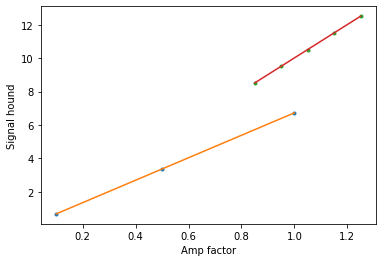

In [7]:
amp_calib_pump, amp_calib_res=calib.full_power_calibration(qm,sgh,amplitude_array_res, amplitude_array_pump, IF_readout, LO_readout, IF_fluxline, LO_fluxline)